In [51]:
import json
import pickle

from matplotlib import pyplot as plt
import numpy as np
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [48]:
def add_attr(stats, attr, attr_dict):
    for day in stats:
        for track in stats[day]:
            song = track['song']
            artist = track['artist']
            a = attr_dict.get((song, artist))
            track[attr] = a
            

def get_genre(track):
    if not track['meta']:
        return ['Unknown']
    genre_list = track['meta']['primary_genres']['music_genre_list']
    if not genre_list:
        return ['Unknown']
    genres = [genre_dict['music_genre']['music_genre_name'] for genre_dict in genre_list]
    return genres


def get_lyrics(stats):
    genre_lyric_dict = {}
    for date in stats:
        for track in stats[date]:
            genres = get_genre(track)
            lyrics = track['lyrics']
            if not lyrics:
                continue
            for genre in genres:
                lyric_set = genre_lyric_dict.get(genre, set())
                lyric_set.add(lyrics)
                genre_lyric_dict[genre] = lyric_set
    return genre_lyric_dict


def get_genre_sentiment(genre_lyric_dict):
    sent_scores = {}
    for genre in genre_lyric_dict:
        scores = []
        lyrics = list(genre_lyric_dict[genre])
        for lyric in lyrics:
            score = np.mean([analyzer.polarity_scores(line)['compound'] for line in lyric.split('\n')])
            scores.append(score)
        sent_scores[genre] = np.mean(scores)
    sent_scores = dict(sorted(sent_scores.items(), key=lambda x: x[1], reverse=True))
    return sent_scores


def show_count_and_sentiment(genre, freq_dict, sent_dict, num=10):
    print(f'{genre:*^30}')
    print(f'Sentiment: {sent_dict[genre]}')
    print(freq_dict[genre].most_common(num))
    
                
def preprocess(genre_lyric_dict):
    genre_lyric_freq = {}
    en_stop = stopwords.words('english')
    for genre in genre_lyric_dict:
        lyric_list = []
        lyrics = genre_lyric_dict[genre]
        for lyric in lyrics:
            lyric = [word.lower() for word in re.split(r'\s', lyric) if word.lower() not in en_stop and word.isalpha()]
            lyric_list.extend(lyric)
        genre_lyric_freq[genre] = Counter(lyric_list)
        
    return genre_lyric_freq

In [43]:
with open('spotify_top_200_with_meta_20170101-20180101.json') as f1, open('spotify_lyrics.pkl', 'rb') as f2, open('spotify_lyrics_freq.pkl', 'rb') as f3:
    stats = json.load(f1)
    lyrics = pickle.load(f2)
    lyrics_count = pickle.load(f3)

In [25]:
# add lyrics
add_attr(stats, 'lyrics', lyrics)

In [26]:
# get unique lyrics for each genre
genre_lyric_dict = get_lyrics(stats)

I'll be using a package called [VADER (Valence Aware Dictionary and sEntiment Reasoner)](https://github.com/cjhutto/vaderSentiment)

`analyzer.polarity_scores(sentence)` will return a dictionary containing the ratio for proportions of the text that fall under positive, neutral, or negative.

`compound` sums the valence of each word, adjusts scores according to rules, and then normalizes the score between -1 (super negative) and 1 (super positive).

According to the authors:
1. positive sentiment: `compound` score >= 0.05
2. neutral sentiment: -0.05 < `compound` < 0.05
3. negative sentiment: `compound` score <= -0.05

In [8]:
analyzer = SentimentIntensityAnalyzer()

In [32]:
# Let's first look at an example
rap = list(genre_lyric_dict['Hip Hop/Rap'])

In [33]:
# This looks negative...
rap[0].split('\n')

['Ooh, ahh, ahh, ahh',
 "Don't go, don't go to sleep",
 "Don't go, stay up and",
 '',
 "Tired of feelin' like I'm trapped in my damn mind",
 "Tired of feelin' like I'm wrapped in a damn lie",
 "Tired of feelin' like my life is a damn game",
 'Nigga really wanna die in the night time',
 '',
 "Only time I feel pain, when I'm feelin' love",
 "That's why it's tatted on my face that I'm damn numb",
 "Only time I'm in my mind, when I'm all alone",
 "That's why I'm never really alone in the night time",
 "Change hoes like clothes, I can't get attached",
 "'Cause these hoes fire starters like lit matches",
 "I've been feelin' really lost, duckin' all attachments",
 "I don't really go outside 'cause I hate traffic",
 "I don't wanna go outside, get caught in traffic, traffic",
 '',
 'Ooh, ahh, ahh, ahh',
 'Don’t go, don’t go to sleep',
 'Don’t go, stay up and',
 '',
 "Tired of feelin' like I'm trapped in my damn mind",
 "Tired of feelin' like I'm wrapped in a damn lie",
 "Tired of feelin' like m

In [31]:
# And it is!
print(np.mean([analyzer.polarity_scores(line)['compound'] for line in rap[0].split('\n')]))

-0.2765583333333333


In [52]:
# What about each genre?
genre_sentiment = get_genre_sentiment(genre_lyric_dict)
genre_sentiment

{'Classical Crossover': 0.3162282051282051,
 'Contemporary Folk': 0.2470125,
 'Celtic Folk': 0.2470125,
 'Punk': 0.2113390728476821,
 'Soul': 0.1947218034174877,
 'Dancehall': 0.19283094907446813,
 'Holiday': 0.15430447689146898,
 'Singer/Songwriter': 0.14398945879770347,
 'Salsa y Tropical': 0.1405831168831169,
 'Soft Rock': 0.13895813953488373,
 'Ambient': 0.13480243902439026,
 'Gospel': 0.13002954545454545,
 'House': 0.12228181687809651,
 'Folk': 0.11621993170615323,
 'Traditional Country': 0.10823527272727274,
 'Christmas': 0.10255611158369234,
 'Alternative Rap': 0.07955026742993848,
 'Vocal': 0.0740297276995305,
 'Garage': 0.0723054054054054,
 'Afro-Beat': 0.0723054054054054,
 'Country': 0.06906931653958231,
 'K-Pop': 0.06808770243072437,
 'Easy Listening': 0.05761714285714285,
 'Pop': 0.057434174960215925,
 'Contemporary Country': 0.05502524698841016,
 'Dirty South': 0.05469857142857144,
 'Teen Pop': 0.050281250000000006,
 'Rock': 0.04995052318350203,
 'Psychedelic': 0.048871794

`Southern Gospel` is super negative for some reason...

In [50]:
show_count_and_sentiment('Southern Gospel', lyrics_count, genre_sentiment)

*******Southern Gospel********
Sentiment: -0.09550689655172415
[('broken', 10), ('halos', 10), ('used', 10), ('shine', 7), ('go', 5), ('seen', 3), ('share', 3), ('folded', 3), ('wings', 3), ('fly', 3)]


Probably because 'broken' is tied for the most used word.

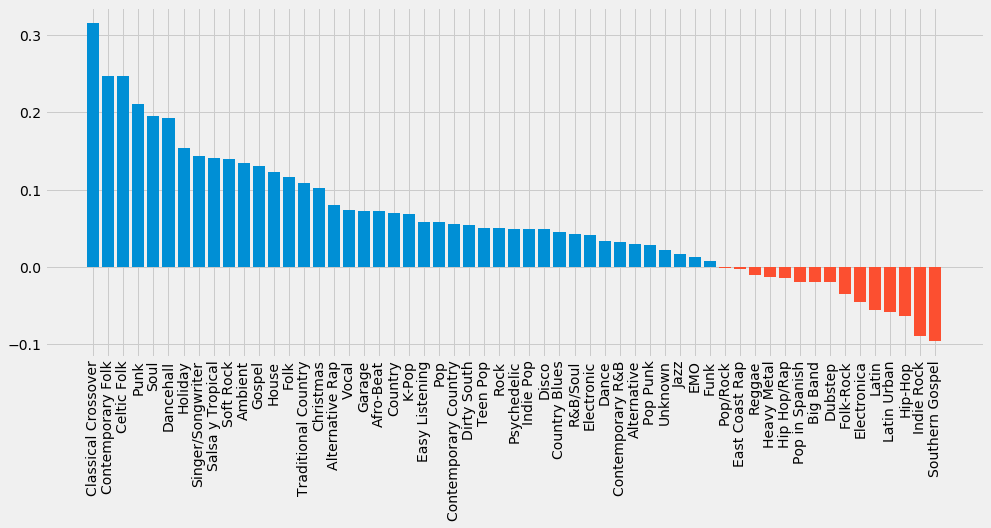

In [73]:
# Pretty plot at the end.
plt.style.use('fivethirtyeight')
fig, ax = plt.subplots(figsize=(15, 6))
labels, values = zip(*genre_sentiment.items())
ax.bar(labels, values, color=['#008fd5' if x > 0 else '#fc4f30' for x in values])
for tick in ax.get_xticklabels():
    tick.set_rotation(90)
plt.show()